In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# Definieer wat waardes voor je k's
k1 = 890000 # kon for E + S to ES
k2 = 0.0225               # koff for ES to E + S
k3 = 210000
k4 = 0.000155
k5 = 0
k6 = 0
kcat = 0

# Definieer de concentraties op T=0 (in eerste instantie: voor inhibitie of substraat)
E0 = 2*10**-9
ES0 = 0
P0 = 0
EI0 = 0
EIi0 = 0  #(EI*)

#Definieer constanten
I0 = 0.8*10**-9
S0 = 25*10**-9
dt = 0.001 #Dit is hoe groot je simulatie tijdstappen zijn

tframe = 1 #save a frame every 60 s
tincub = 0 #incubate for 1800 s
tsub = 3600  # Run with substrate for 1800 s

In [55]:
concentraties = np.array([E0, ES0, P0, EI0, EIi0], dtype=np.double) #matrix van concentraties

In [56]:
# Voor toevoeging van S



                        # [         E,       ES, P,     EI, EI*]
#tijdevolutie0 = np.array([[-k3*I-k1*S,  k2+kcat, 0,     k4,   0],  #E
#                          [      k1*S, -k2-kcat, 0,      0,   0],  #ES
#                          [         0,     kcat, 0,      0,   0],  #P
#                          [      k3*I,        0, 0, -k4-k5,  k6],  #EI
#                          [         0,        0, 0,     k5, -k6]]) #EI*

#verandering in E   = [E]*(-k3*I-k1*S) + [ES]*(k2+kcat)  + [P]*(0) + [EI]*(k4)     + [EI*]*(0)
#verandering in ES  = [E]*(k1*S)       + [ES]*(-k2-kcat) + [P]*(0) + [EI]*(0)      + [EI*]*(0)
#verandering in P   = [E]*(0)          + [ES]*(kcat)     + [P]*(0) + [EI]*(0)      + [EI*]*(0)
#verandering in EI  = [E]*(k3*I)       + [ES]*(0)        + [P]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
#verandering in EI* = [E]*(0)          + [ES]*(0)        + [P]*(0) + [EI]*(k5)     + [EI*]*(-k6)

In [57]:
# Maak een lijst van kopien van de concentraties
S=0 # Geen S in je systeem

plot = [concentraties.copy()]

tijdconc = concentraties
t = 0
# Voor toevoging van S (tincub/dt stappen = 30min)
for i in range(int(tincub/dt)):
    t+= 1
    I = I0-(tijdconc[3]+tijdconc[4]) #subtract EI and EI* from I0
                            # [         E,       ES, P,     EI, EI*]
    tijdevolutie0 = np.array([[-k3*I-k1*S,  k2+kcat, 0,     k4,   0],  #E
                              [      k1*S, -k2-kcat, 0,      0,   0],  #ES
                              [         0,     kcat, 0,      0,   0],  #P
                              [      k3*I,        0, 0, -k4-k5,  k6],  #EI
                              [         0,        0, 0,     k5, -k6]]) #EI*
    tijdconc += np.dot(tijdevolutie0*dt, tijdconc) # Doe 1 dt tijdstap
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    
    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst
  
# Na toevoeging van S (tsub/dt stappen)
S=S0

for i in range(int(tsub/dt)):
    t += 1
    I = I0-(tijdconc[3]+tijdconc[4]) #subtract EI and EI* from I0
    S = S0-(tijdconc[1]+tijdconc[2]) #Subtract ES and P from S0
    tijdevolutie1 = np.array([[-k3*I-k1*S, k2+kcat, 0, k4, 0],
                         [k1*S, -k2-kcat, 0, 0, 0],
                         [0, kcat, 0, 0, 0],
                         [k3*I, 0, 0, -k4-k5, k6],
                         [0, 0, 0, k5, -k6]])
    tijdconc += np.dot(tijdevolutie1*dt, tijdconc) #Doe 1 dt tijdstap
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    
    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst


In [58]:
# Splits de lijst van figuren in E, ES, P, EI en EI*
Eplot = [] 
ESplot = []
Pplot = []
EIplot = []
EIiplot = []
EItot = []
for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 

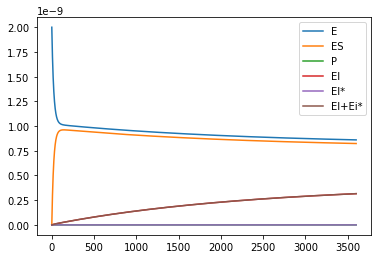

In [59]:
# Plot de figuren
labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*")
for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    plt.plot(y, label=labels[i])
plt.legend()

(0.0, 2e-09)

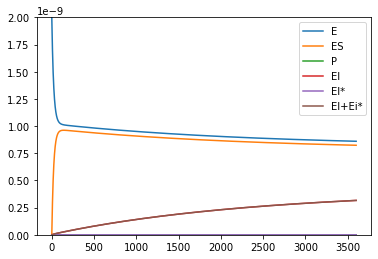

In [60]:
# Plot de figuren
labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*")
for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    plt.plot(y, label=labels[i])
plt.legend()
plt.ylim(0,E0) #zoom in tot E0

In [61]:
print(Eplot)

[2e-09, 1.956189316569184e-09, 1.9143666925851613e-09, 1.8744387793515697e-09, 1.8363168688420959e-09, 1.7999166407616421e-09, 1.765157925274661e-09, 1.7319644802766565e-09, 1.7002637821776385e-09, 1.6699868292503395e-09, 1.6410679566725512e-09, 1.6134446624622289e-09, 1.5870574435673581e-09, 1.5618496414301138e-09, 1.5377672963973095e-09, 1.5147590103971505e-09, 1.492775817345998e-09, 1.4717710607889921e-09, 1.4517002783149281e-09, 1.4325210923194827e-09, 1.414193106721578e-09, 1.3966778092660018e-09, 1.3799384790713526e-09, 1.3639400991062677e-09, 1.3486492732987993e-09, 1.3340341480041539e-09, 1.320064337574571e-09, 1.3067108537923694e-09, 1.2939460389430764e-09, 1.2817435023202274e-09, 1.2700780599670437e-09, 1.2589256774727216e-09, 1.2482634156527344e-09, 1.2380693789533448e-09, 1.228322666430558e-09, 1.2190033251629883e-09, 1.2100923059668252e-09, 1.2015714212890596e-09, 1.1934233051626478e-09, 1.1856313751142218e-09, 1.1781797959214802e-09, 1.1710534451233628e-09, 1.164237880191

In [62]:
import pandas as pd

In [63]:
dataframe = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "ES":ESplot, "P":Pplot})

In [64]:
print(dataframe.to_csv())

,E,EI,EIi,ES,P
0,2e-09,0.0,0.0,0.0,0.0
1,1.956189316569184e-09,3.322003273434793e-13,0.0,4.347848310347715e-11,0.0
2,1.9143666925851613e-09,6.570257047218635e-13,0.0,8.49762817101221e-11,0.0
3,1.8744387793515697e-09,9.748117810777037e-13,0.0,1.2458640886735776e-10,0.0
4,1.8363168688420959e-09,1.285878180544906e-12,0.0,1.6239725297736416e-10,0.0
5,1.7999166407616421e-09,1.5905293189899804e-12,0.0,1.9849282991937258e-10,0.0
6,1.765157925274661e-09,1.88905517452237e-12,0.0,2.3295301955082244e-10,0.0
7,1.7319644802766565e-09,2.1817320149403058e-12,0.0,2.6585378770840866e-10,0.0
8,1.7002637821776385e-09,2.4688230848573487e-12,0.0,2.972673947375122e-10,0.0
9,1.6699868292503395e-09,2.7505792550524896e-12,0.0,3.272625914946146e-10,0.0
10,1.6410679566725512e-09,3.027239636401373e-12,0.0,3.559048036910513e-10,0.0
11,1.6134446624622289e-09,3.299032160576263e-12,0.0,3.832563053771988e-10,0.0
12,1.5870574435673581e-09,3.5661741295467306e-12,0.0,4.09376382303097e-10,0.0
13,1.5618496414301138e-09,3.8